## Loading libraries

In [1]:
#options(warn = 0)

library(tidyverse)
library(tidymodels)
library(stacks)
library(ggplot2)
library(tictoc)
library(vip)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ broom        1.0.6      ✔ rsample      1.2.1 
✔ dials        1.2.1      ✔ tune         1.2.1 
✔ infer        1.0.7      ✔ workflows    1.1.4 
✔ modeldata    1.4.0      ✔ workflowsets 1.1.0 
✔ parsnip      1.2.1      ✔ yardstick    1.3.1 
✔ recipes      1.0.10     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ 

## Extracting train and test data

In [2]:
set.seed(0)

train <- tibble(read.csv("/kaggle/input/titanic/train.csv"))
test  <- tibble(read.csv("/kaggle/input/titanic/test.csv"))

head(train)
head(test)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
<int>,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<chr>,<chr>
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,,S
6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,,Q


PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
<int>,<int>,<chr>,<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<chr>,<chr>
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,,S
897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,,S


## Feature engineering on the train data set: FamilySize, IsAlone, SocialClass, HasCabin and Age
Furthermore, we reorder the Survived factor so that "1" is the response level we are interested in predicting.

Warning message:
“Removed 177 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


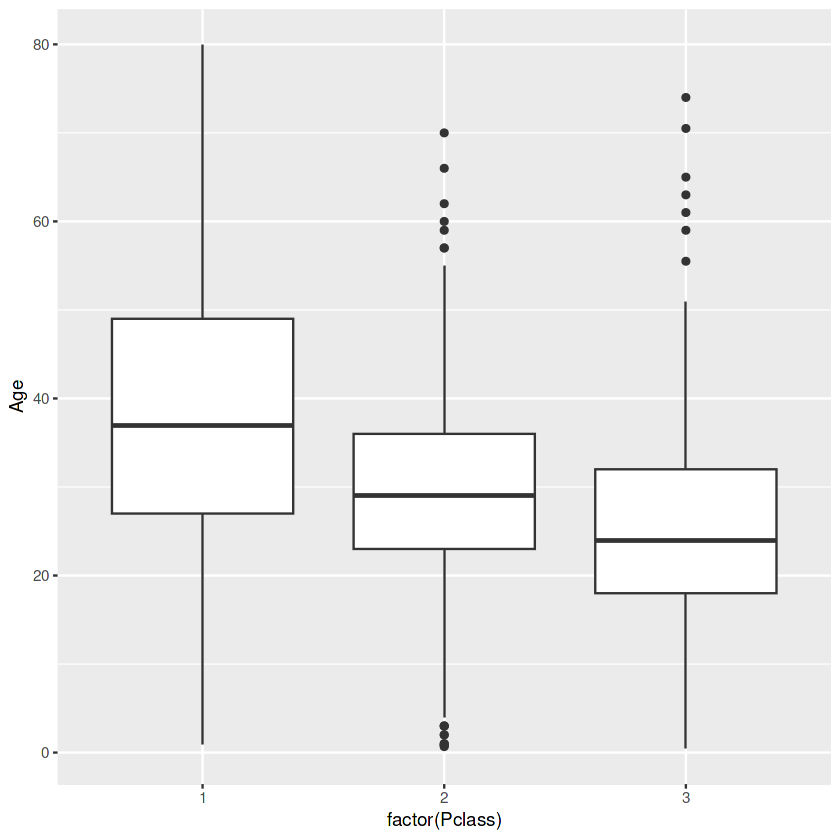

In [3]:
train %>% ggplot(aes(factor(Pclass), Age)) + geom_boxplot()

We see that people in class 1 were significantly older than those in class 3 and 2. Therefore, using step_impute_median for Age would introduce bias into our dataset. Instead, we impute by median age grouped by Pclass.

In [4]:
(age_median_by_pclass <- train %>% select(Pclass, Age) %>% group_by(Pclass) %>% summarize(median_age = median(Age, na.rm = T)))
Age_imputed_train <- ifelse(!is.na(train$Age), train$Age, ifelse(train$Pclass == 1, 37, ifelse(train$Pclass == 2, 29, 24)))

Pclass,median_age
<int>,<dbl>
1,37
2,29
3,24


In [5]:
train_trans <- train %>% mutate(
    across(SibSp | Parch, as.numeric),
    FamilySize = SibSp + Parch + 1,
    IsAlone = factor(ifelse(FamilySize > 1, 1, 0)),
    SocialClass = str_split(Name, ", ") %>% sapply(function(x) x[2]) %>% str_split("\\. ") %>% sapply(function(x) x[1]),
    HasCabin = factor(ifelse(Cabin != "", 1, 0)),
    across((where(is.character) & !Name & !Ticket), as.factor),
    Survived = factor(Survived, levels = c(1, 0)),
    Pclass = factor(Pclass),
    Fare = log(Fare + 0.1),
    Age = Age_imputed_train
)
head(train_trans)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone,SocialClass,HasCabin
<int>,<fct>,<fct>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,1.994700,,S,2,1,Mr,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,4.268064,C85,C,2,1,Mrs,1
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,2.082562,,S,1,0,Miss,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,3.974058,C123,S,2,1,Mrs,1
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,2.098018,,S,1,0,Mr,0
6,0,3,"Moran, Mr. James",male,24,0,0,330877,2.146902,,Q,1,0,Mr,0


What kinds of titles have we found? The dataset contains a few rare ones, so we should lump the rarest ones into a factor "Other".

In [6]:
train_trans %>% count(SocialClass) %>% arrange(desc(n))

SocialClass,n
<fct>,<int>
Mr,517
Miss,182
Mrs,125
Master,40
Dr,7
Rev,6
Col,2
Major,2
Mlle,2


Ms, Mlle (Mademoiselle) and Mme (Madame) should be unified into "Miss" and "Mrs", respectively. "Military" and "Noble" might be other useful factors, so let us make sure that military personnel and nobles didn't have a significantly different survival rate on the train set:

`summarise()` has grouped output by 'SocialClass'. You can override using the
`.groups` argument.


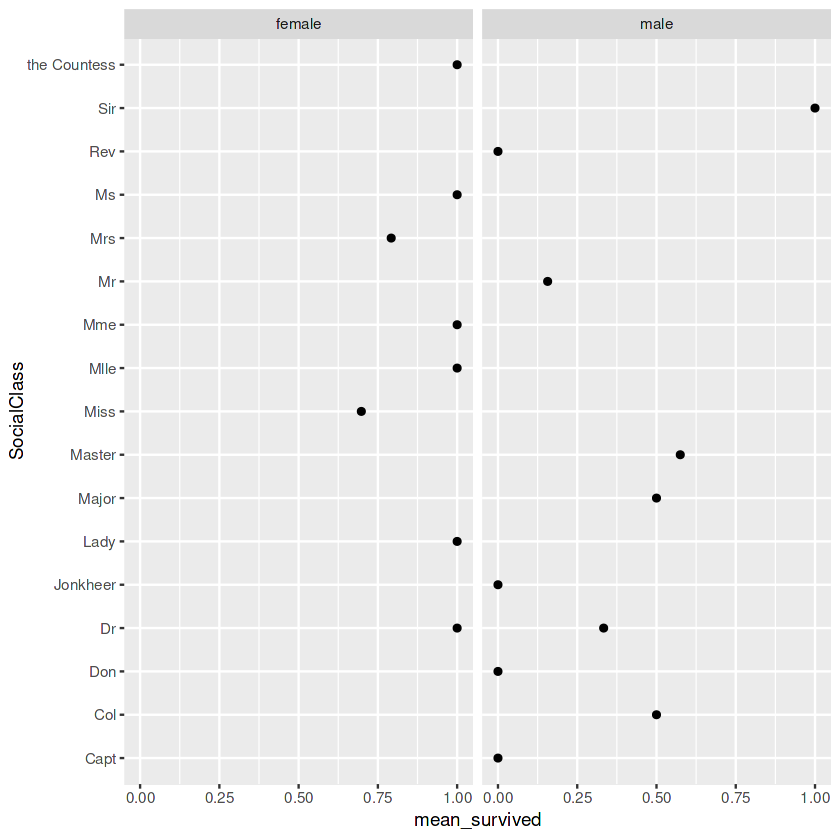

In [7]:
train_trans %>% 
    group_by(SocialClass, Sex) %>% 
    summarize(mean_survived = mean(ifelse(Survived == 1, 1, 0))) %>% 
    ggplot(aes(SocialClass, mean_survived)) + 
    geom_point() + 
    facet_wrap(~Sex) + 
    coord_flip()

Actually, military and noble status might have an effect on survival rates. Let us introduce two new factors: "Noble" and "Military". We will lump the rest into "Other". 

NOTE: At this point, I went down to the section where I transform the test data, and looked at the factor levels in there, so that my function considers all factors, even the ones invisible to the train set. Not necessary, but more tidy in my opinion. The factors found in the test dataset were:
'Col' 'Dona' 'Dr' 'Master' 'Miss' 'Mr' 'Mrs' 'Ms' 'Rev' (the only new factor is "Dona")

In [8]:
levels(train_trans$SocialClass)

[1] "Capt"         "Col"          "Don"          "Dr"           "Jonkheer"    
 [6] "Lady"         "Major"        "Master"       "Miss"         "Mlle"        
[11] "Mme"          "Mr"           "Mrs"          "Ms"           "Rev"         
[16] "Sir"          "the Countess"

In [9]:
socialClassMap <- function(.x) ifelse(
    .x %in% c("Ms", "Mlle"), "Miss", 
    ifelse(.x %in% c("Mme"), "Mrs", 
           ifelse(.x %in% c("the Countess", "Jonkheer", "Don", "Sir", "Lady"), "Noble", 
                  ifelse(.x %in% c("Capt", "Col", "Major"), "Military", 
                         ifelse(.x %in% c("Mr", "Miss", "Mrs", "Master"), .x, "Other")))))

train_trans$SocialClass <- fct_relabel(train_trans$SocialClass, ~ socialClassMap(.x))

`summarise()` has grouped output by 'SocialClass'. You can override using the
`.groups` argument.


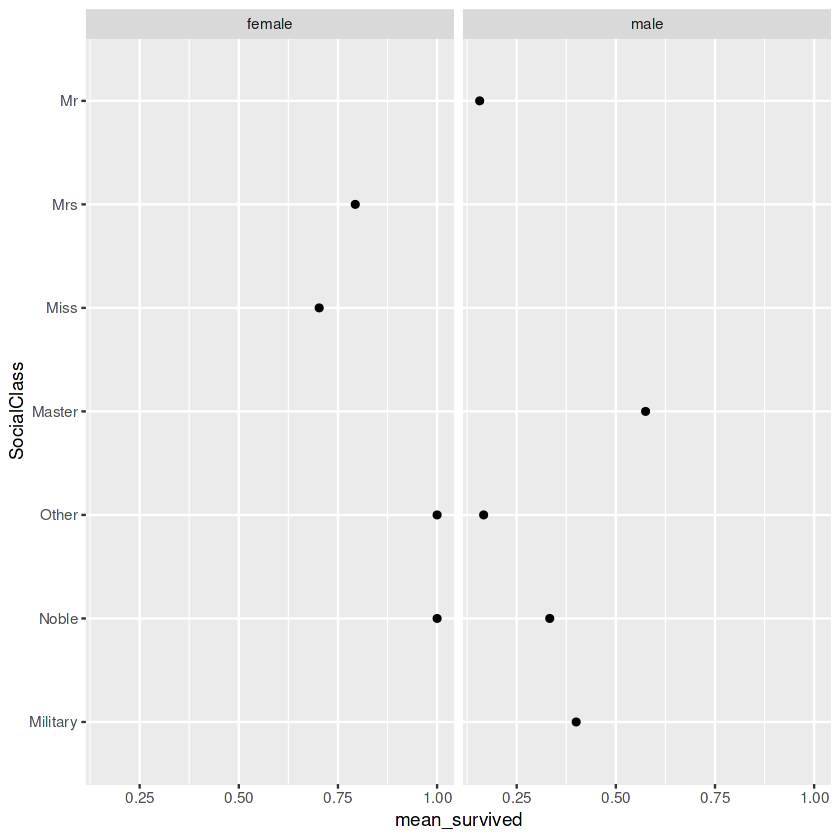

In [10]:
train_trans %>% 
    group_by(SocialClass, Sex) %>% 
    summarize(mean_survived = mean(ifelse(Survived == 1, 1, 0))) %>% 
    ggplot(aes(SocialClass, mean_survived)) + 
    geom_point() + 
    facet_wrap(~Sex) + 
    coord_flip()

In [11]:
train %>% group_by(Sex) %>% summarize(prop_present = n() / nrow(train))
train %>% group_by(Sex) %>% summarize(mean_survived = mean(Survived))
train %>% group_by(Survived) %>% summarize(prop_total = n() / nrow(train))

#mutate(HasCabin = !is.na(Cabin)) %>%

Sex,prop_present
<chr>,<dbl>
female,0.352413
male,0.647587


Sex,mean_survived
<chr>,<dbl>
female,0.7420382
male,0.1889081


Survived,prop_total
<int>,<dbl>
0,0.6161616
1,0.3838384


We can see that 35% of all passengers were female. Furthermore, of all female passengers, 74% survived, while 19% of all male passengers survived. Overall, a naive model which predicts 0 on every passenger would reach an accuracy of 62%, while a less naive model basing the output simply on a passenger's sex would reach an accuracy of 79% ($0.35 \cdot 0.74 + 0.65 \cdot (1 - 0.19)$).

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


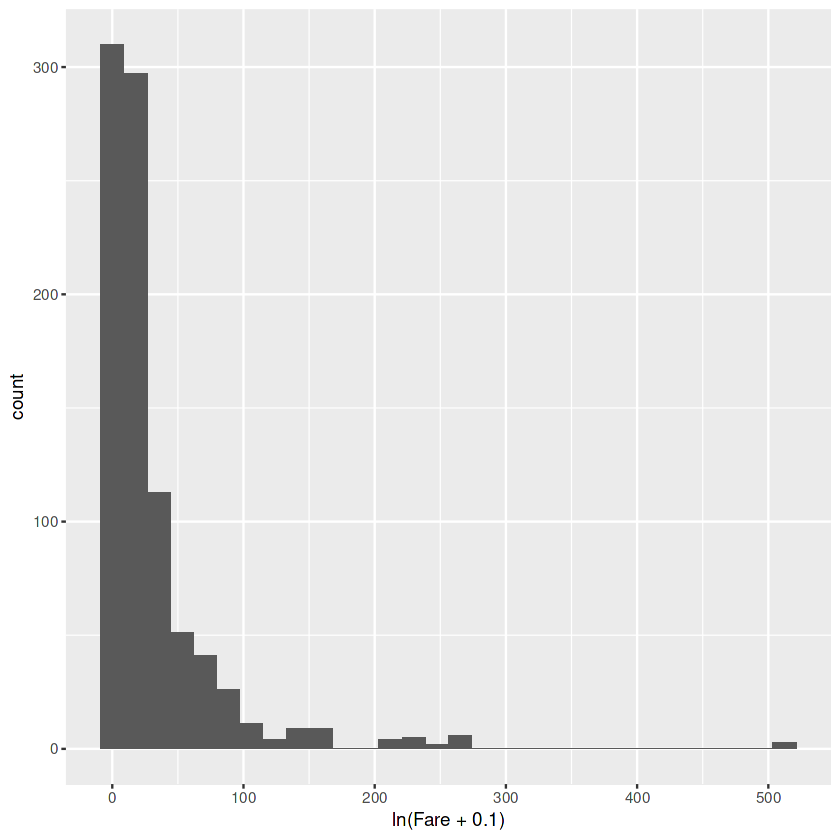

In [12]:
train %>% ggplot(aes(Fare)) + geom_histogram() + xlab("ln(Fare + 0.1)")

Once we've taken the log (remember the earlier preprocessing step), Fare ends up being more or less normally distributed.

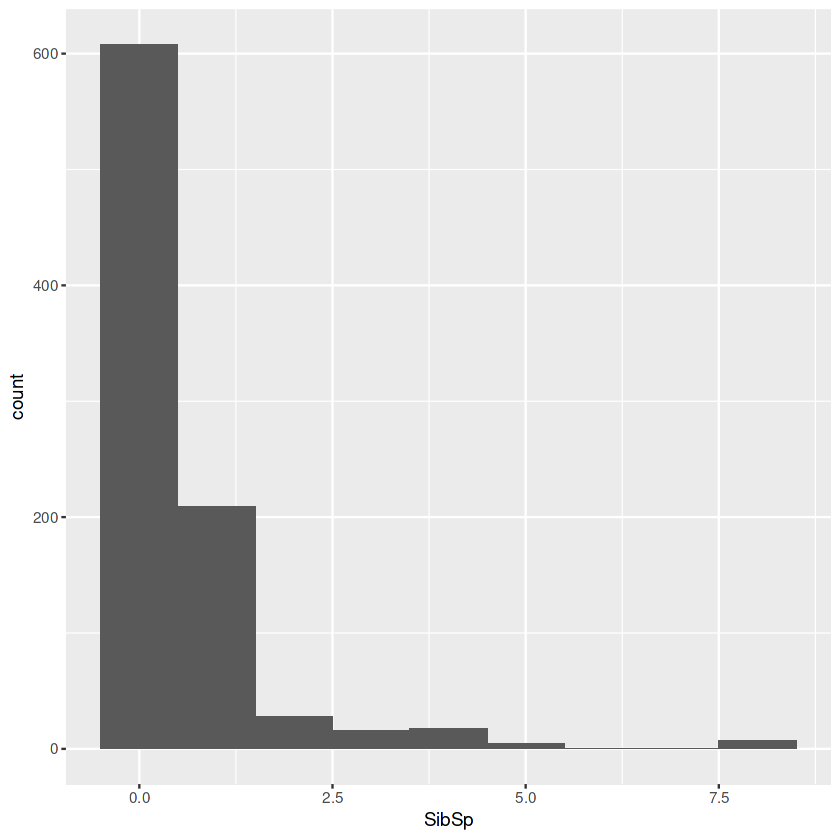

In [13]:
train %>% ggplot(aes(SibSp)) + geom_histogram(binwidth = 1)

SibSp is extremely right skewed with a large cluster on 0. It might be worth it to introduce a variable "isWithSiblings", but our engineered variable "IsAlone" is already more or less representing this.

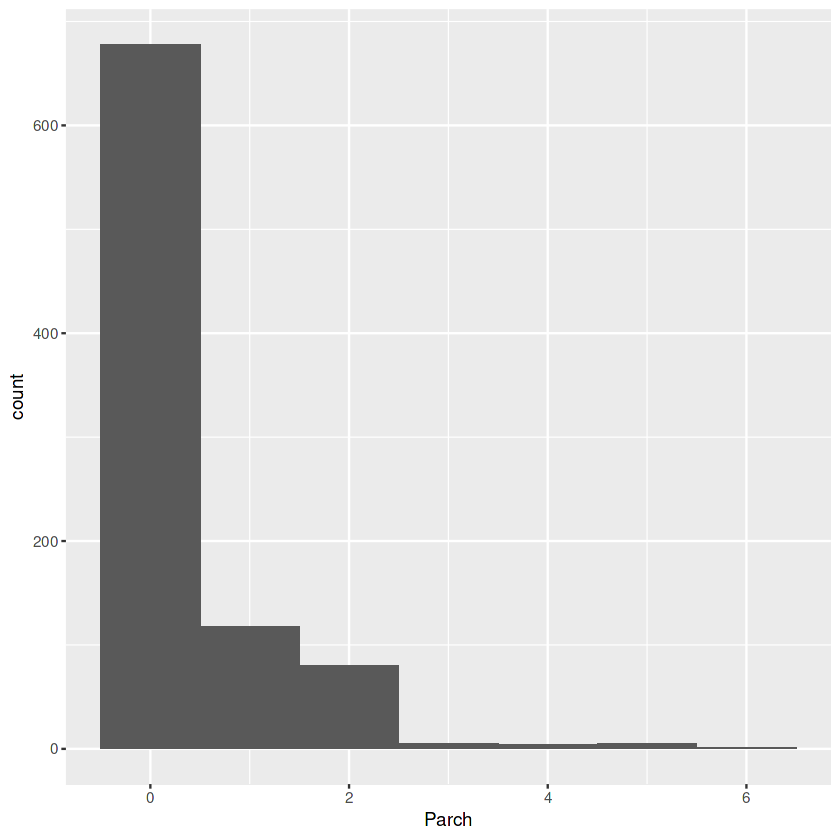

In [14]:
train %>% ggplot(aes(Parch)) + geom_histogram(binwidth = 1)

Similarly, Parch is right-skewed with a large cluster on 0. Another hint that FamilySize and IsAlone might be helpful variables.

Warning message:
“Removed 177 rows containing non-finite outside the scale range
(`stat_density()`).”


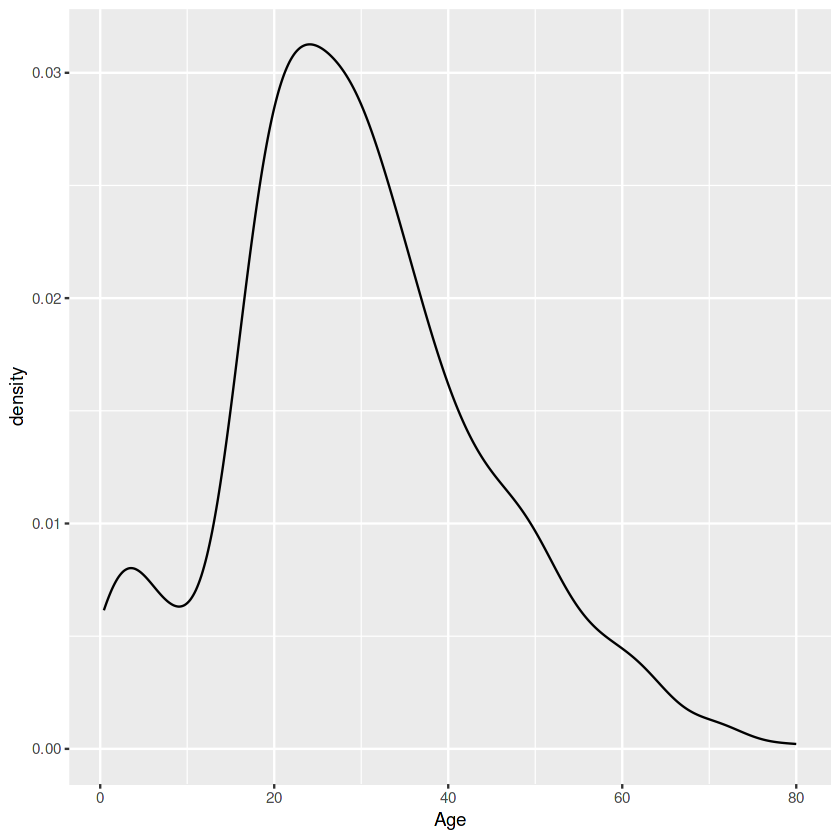

In [15]:
train %>% ggplot(aes(Age)) + geom_density()

Age is very roughly normally distributed with a peak around Age 25. Probably no need to do anything here.

`summarise()` has grouped output by 'Sex'. You can override using the `.groups`
argument.


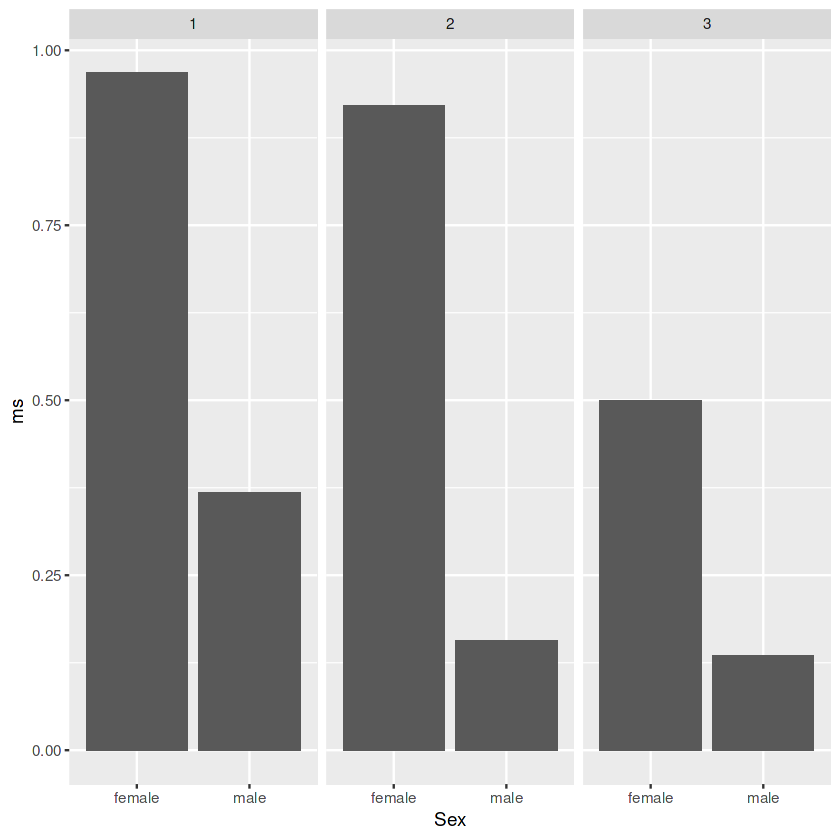

In [16]:
train %>% group_by(Sex, Pclass) %>% summarize(ms = mean(Survived)) %>% ggplot(aes(Sex, ms)) + geom_col(position = "dodge") + facet_wrap(~ Pclass)

Among male survivors, class 1 is severely overrepresented, while for female passengers, only those in class 3 had significantly different survival odds. Clearly, Sex and Pclass are the most influential variable on whether a passenger survived, but the package vip will later tell us more about this.

`summarise()` has grouped output by 'Age'. You can override using the `.groups`
argument.
`geom_smooth()` using formula = 'y ~ x'


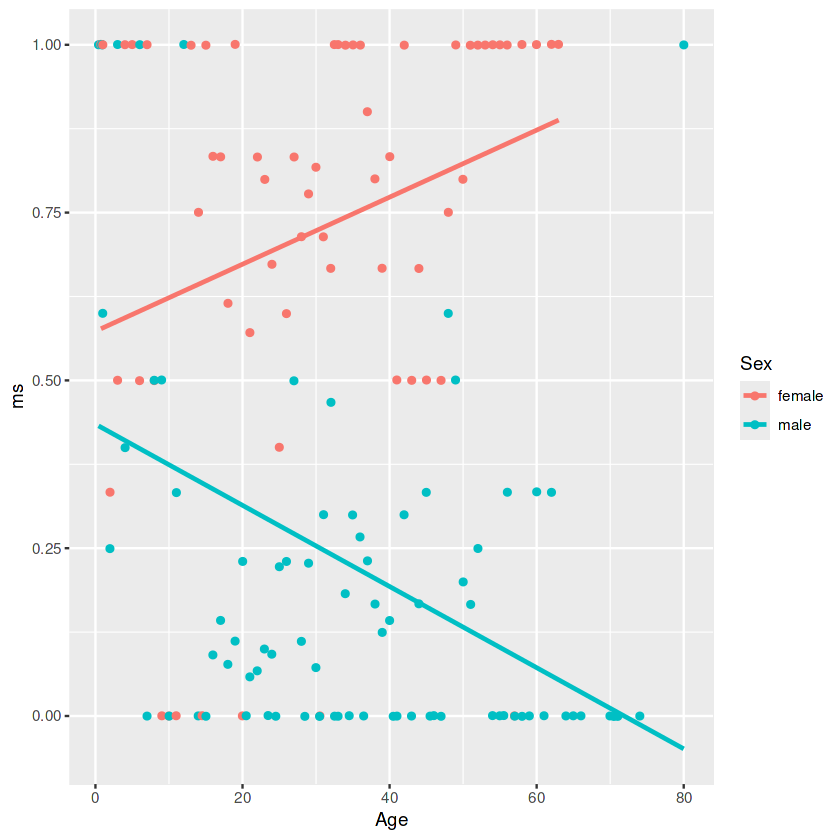

In [17]:
train_trans %>% 
    filter(!is.na(Age)) %>% 
    group_by(Age, Sex) %>% 
    summarize(ms = mean(ifelse(Survived == 1, 1, 0))) %>% 
ggplot(aes(Age, ms, color = Sex)) + geom_jitter() + geom_smooth(method = "lm", se = F)

Again, we see that female passengers survived much more often than male ones. Unfortunately, the trend line here is not valuable because a proper trend line should respect the size of each age group. Therefore, it is hard to recognize whether there is a trend in Survived over Age, but let's just see what the model returns us.

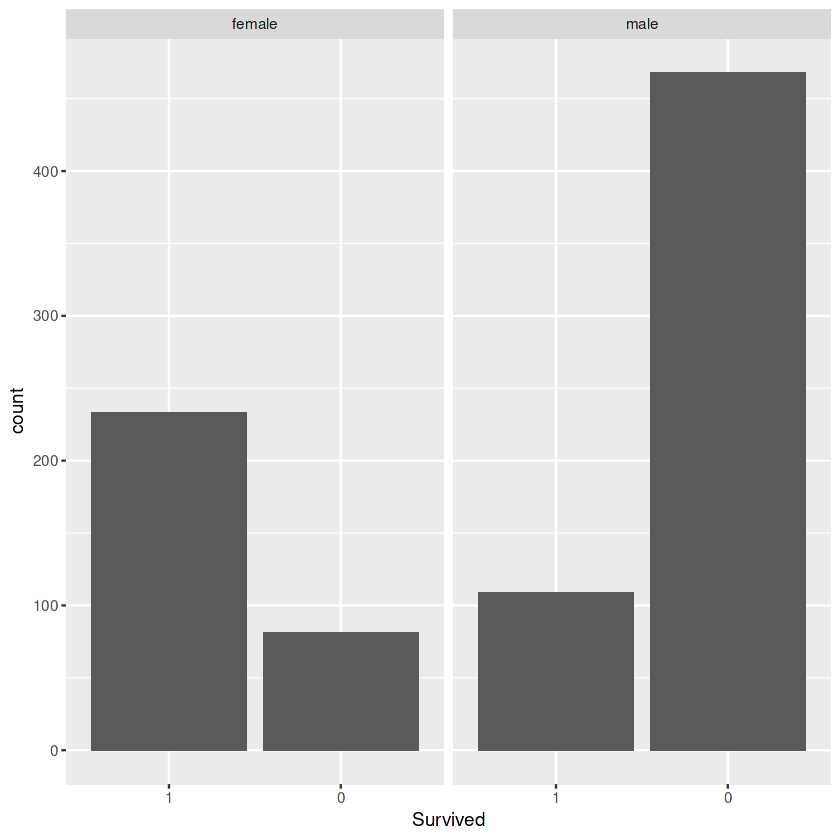

In [18]:
train_trans %>% ggplot(aes(Survived)) + facet_wrap(~ Sex) + stat_count()

## Transforming the test data

In [19]:
Age_imputed_test <- ifelse(!is.na(test$Age), test$Age, ifelse(test$Pclass == 1, 37, ifelse(test$Pclass == 2, 29, 24)))

In [20]:
test_trans <- test %>% mutate(
    across(SibSp | Parch, as.integer), 
    FamilySize = SibSp + Parch + 1, 
    IsAlone = factor(ifelse(FamilySize > 1, 1, 0)), 
    SocialClass = str_split(Name, ", ") %>% sapply(function(x) x[2]) %>% str_split("\\. ") %>% sapply(function(x) x[1]), 
    HasCabin = factor(ifelse(Cabin != "", 1, 0)),
    across((where(is.character) & !Name & !Ticket), as.factor),
    Pclass = factor(Pclass),
    Fare = log(Fare + 0.1),
    Age = Age_imputed_test
)

test_trans$SocialClass <- fct_relabel(test_trans$SocialClass, ~ socialClassMap(.x))
head(test_trans)

PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone,SocialClass,HasCabin
<int>,<fct>,<chr>,<fct>,<dbl>,<int>,<int>,<chr>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,2.070552,,Q,1,0,Mr,0
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,1.960095,,S,2,1,Mrs,0
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,2.281106,,Q,1,0,Mr,0
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,2.170481,,S,1,0,Mr,0
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,2.516688,,S,3,1,Mrs,0
897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,2.232699,,S,1,0,Mr,0


## Preparing v-fold CV
We're using 6 folds with 2 repetitions to achieve some level of balance between quality of results and runtime. Remember to enable stratified sampling so that we don't run into any issues with unbalanced datasets.

In [24]:
folds <- vfold_cv(train_trans, 10, 2, strata = Survived)

## Setting up the workflow
We use a random forest with the ranger engine, setting the importance parameter so that we can later apply vip. trees is fixed to 1000 while we tune mtry and min_n on a regular grid with 6 levels. This will take a while.

In [22]:
#model_rf <- rand_forest(mtry = tune(), trees = 1000, min_n = tune()) %>% 
model_rf <- rand_forest(mtry = 4, trees = 1000, min_n = 21) %>% # Parameters taken from the most successful run
    set_engine("ranger", importance = "impurity") %>% 
    set_mode("classification")

#grid_rf  <- expand_grid(mtry = c(8, 10, 12, 15), min_n = floor(seq(12, 40, length.out = 10)))
grid_rf <- grid_regular(mtry() %>% finalize(train_trans), min_n(), levels = 5)

control_grid <- control_stack_grid()

rec <- recipe(Survived ~ ., train_trans) %>% 
    update_role(PassengerId, new_role = "ID") %>%
    step_rm(Name, Ticket, Cabin, Parch, SibSp) %>%
    step_zv(everything()) %>%
    step_normalize(all_numeric_predictors()) %>%
    step_impute_median(all_numeric_predictors()) %>%
    step_impute_mode(all_factor_predictors()) %>%
    step_dummy(all_factor_predictors())

wflow <- workflow() %>% add_model(model_rf) %>% add_recipe(rec)

## Perform the CV
We run the CV and remember to set the control grid to parallelize over everything.

In [25]:
tic()
res_rf <- wflow %>% tune_grid(resamples = folds, grid = grid_rf, control = control_grid)
toc()

163.055 sec elapsed


Tuning the Random Forest on a $5^2$ grid using 2x6-fold CV took 163 seconds.

**Best model (running on a $5^2$ grid using 2x6-fold CV; accuracy 0.8100559, AUC 0.8714097)**:
* mtry: 4
* min_n: 21

In [26]:
res_rf %>% show_best(metric="accuracy", n=10)

mtry,min_n,.metric,.estimator,mean,n,std_err,.config
<int>,<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
4,21,accuracy,binary,0.8355251,12,0.007493913,Preprocessor1_Model12
8,11,accuracy,binary,0.8332766,12,0.006761656,Preprocessor1_Model08
4,30,accuracy,binary,0.8327174,12,0.007375936,Preprocessor1_Model17
8,21,accuracy,binary,0.8321505,12,0.008208936,Preprocessor1_Model13
8,30,accuracy,binary,0.8321505,12,0.008660534,Preprocessor1_Model18
4,40,accuracy,binary,0.8316026,12,0.006731809,Preprocessor1_Model22
16,30,accuracy,binary,0.8315875,12,0.008840885,Preprocessor1_Model20
16,11,accuracy,binary,0.8310395,12,0.006559159,Preprocessor1_Model10
12,30,accuracy,binary,0.8304689,12,0.008057045,Preprocessor1_Model19


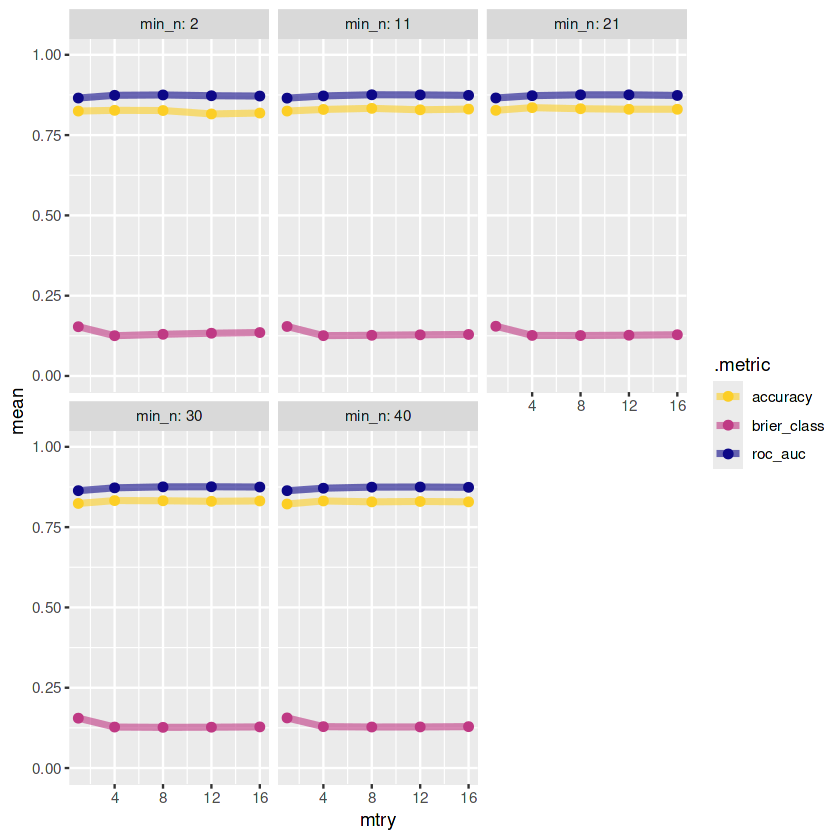

In [27]:
res_rf %>% collect_metrics %>% 
    ggplot(aes(mtry, mean, color = .metric)) + 
    facet_wrap(~ min_n, labeller = "label_both") +
    geom_line(linewidth = 1.5, alpha = .6) + 
    geom_point(size = 2) + 
    scale_color_viridis_d(option = "plasma", begin = .9, end = 0) +
    ylim(0, 1)

## Extract best model, finalize workflow and obtain final fit

In [28]:
(best_model_rf <- res_rf %>% select_best(metric = "accuracy"))

mtry,min_n,.config
<int>,<int>,<chr>
4,21,Preprocessor1_Model12


In [29]:
(final_wf_rf <- wflow %>% finalize_workflow(best_model_rf))

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: rand_forest()

── Preprocessor ────────────────────────────────────────────────────────────────
6 Recipe Steps

• step_rm()
• step_zv()
• step_normalize()
• step_impute_median()
• step_impute_mode()
• step_dummy()

── Model ───────────────────────────────────────────────────────────────────────
Random Forest Model Specification (classification)

Main Arguments:
  mtry = 4
  trees = 1000
  min_n = 21

Engine-Specific Arguments:
  importance = impurity

Computational engine: ranger 


#### Metrics: Random Forest

In [30]:
split <- initial_split(train_trans, .8, strata = Survived)

final_fit_rf <- final_wf_rf %>% last_fit(split)
final_fit_rf %>% collect_metrics

## Obtain variable importance, final look at ROC
Looks like the most significant predictors for whether a passenger survived were their sex, their ticket class, the price of their ticket and their age. FamilySize had a minor impact as well. The ROC that we ended up with also looks relatively nice, with a sensitivity of around 80% while keeping specificity very close to 100%.

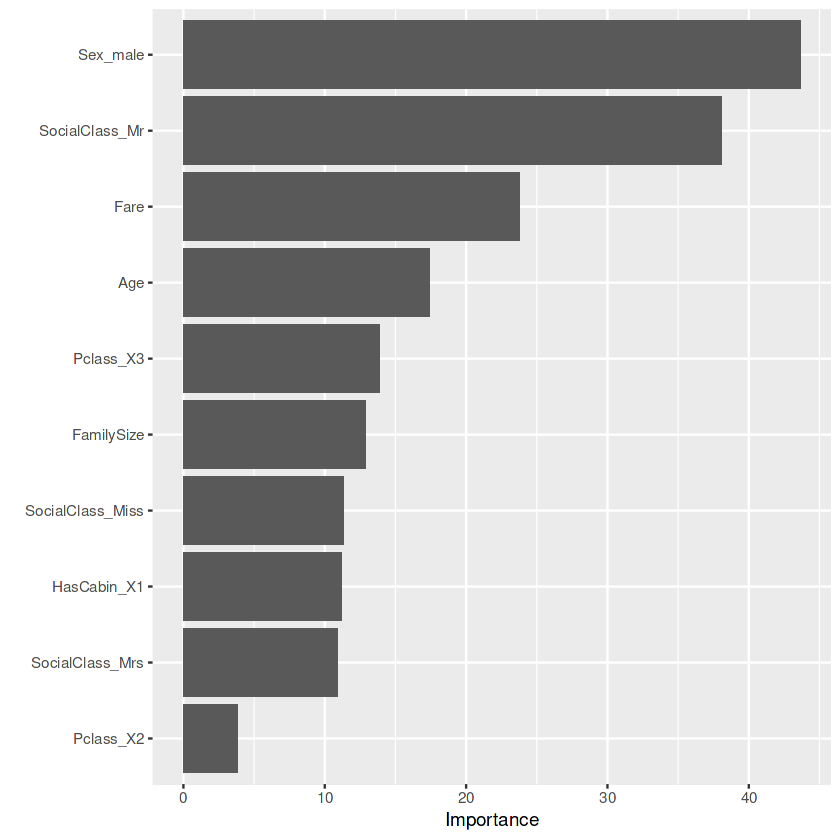

In [31]:
final_fit_rf %>% extract_fit_parsnip %>% vip

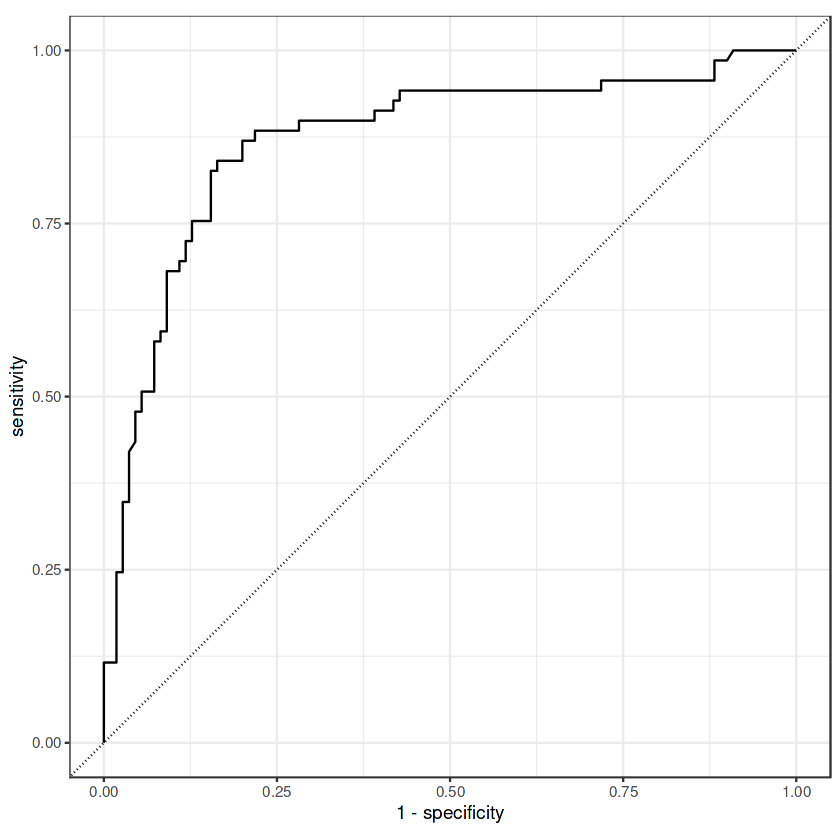

In [32]:
final_fit_rf %>% collect_predictions %>% roc_curve(Survived, .pred_1) %>% autoplot

In [33]:
final_fit_rf %>% extract_workflow

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: rand_forest()

── Preprocessor ────────────────────────────────────────────────────────────────
6 Recipe Steps

• step_rm()
• step_zv()
• step_normalize()
• step_impute_median()
• step_impute_mode()
• step_dummy()

── Model ───────────────────────────────────────────────────────────────────────
Ranger result

Call:
 ranger::ranger(x = maybe_data_frame(x), y = y, mtry = min_cols(~4L,      x), num.trees = ~1000, min.node.size = min_rows(~21L, x),      importance = ~"impurity", num.threads = 1, verbose = FALSE,      seed = sample.int(10^5, 1), probability = TRUE) 

Type:                             Probability estimation 
Number of trees:                  1000 
Sample size:                      712 
Number of independent variables:  17 
Mtry:                             4 
Target node size:                 21 
Variable importance mode:         impurity 
Splitrule:                  

## Obtain and evaluate more models
We will now proceed to fit more models, trying to find the best set of hyperparameters for each model in a reasonable timespan.

### Logistic Regression


In [56]:
logreg_penalty <- 7.847600e-3
logreg_mixture <- 3.157895e-1
isTuningLogReg <- F

model_logreg <- if(isTuningLogReg) {
    logistic_reg(penalty = tune(), mixture = tune())
} else {
    logistic_reg(penalty = logreg_penalty, mixture = logreg_mixture)
} %>% 
    set_engine("glmnet") %>% 
    set_mode("classification")

wflow_logreg <- wflow %>% update_model(model_logreg)

res_logreg <- if(isTuningLogReg) {
    tic()
    grid_logreg  <- grid_regular(penalty(), mixture(), levels = 20)
    out <- wflow_logreg %>% tune_grid(resamples = folds, grid = grid_logreg, control = control_grid)
    toc()
    out
} else {
    wflow_logreg %>% fit(train_trans)
}

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: logistic_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
6 Recipe Steps

• step_rm()
• step_zv()
• step_normalize()
• step_impute_median()
• step_impute_mode()
• step_dummy()

── Model ───────────────────────────────────────────────────────────────────────

Call:  glmnet::glmnet(x = maybe_matrix(x), y = y, family = "binomial",      alpha = ~logreg_mixture) 

   Df  %Dev  Lambda
1   0  0.00 0.84580
2   2  1.80 0.77060
3   2  3.64 0.70220
4   2  5.41 0.63980
5   2  7.10 0.58300
6   2  8.69 0.53120
7   2 10.20 0.48400
8   4 11.88 0.44100
9   4 13.83 0.40180
10  4 15.64 0.36610
11  5 17.36 0.33360
12  6 18.99 0.30400
13  6 20.46 0.27700
14  6 21.81 0.25230
15  6 23.02 0.22990
16  7 24.13 0.20950
17  7 25.14 0.19090
18  7 26.05 0.17390
19  8 26.90 0.15850
20  9 27.70 0.14440
21  9 28.42 0.13160
22 11 29.31 0.11990
23 11 30.19 0.10920
24 11 31.0

109 seconds to tune on a $2^{20}$ grid using 2x10-fold CV.

**Best model (on a $2^{20}$ grid using 2x10-fold CV; acc 0.8324022, AUC 0.9002635):**
* penalty: 7.8476e-3
* mixture: 0.3157895

In [58]:
if (isTuningLogReg) res_logreg %>% show_best(metric = "accuracy", n = 20)

In [59]:
if (isTuningLogReg) res_logreg %>% collect_metrics %>% 
    ggplot(aes(penalty, mean, color = .metric)) + 
    facet_wrap(~ mixture, labeller = "label_both") +
    geom_line(linewidth = 1.5, alpha = .6) + 
    geom_point(size = 2) + 
    scale_color_viridis_d(option = "plasma", begin = .9, end = 0) +
    ylim(0, 1)

In [60]:
if (isTuningLogReg) (best_model_logreg <- res_logreg %>% select_best(metric = "accuracy"))

In [61]:
if (isTuningLogReg) final_wf_logreg <- wflow_logreg %>% finalize_workflow(best_model_logreg)

#### Metrics: Logistic Regression

In [62]:
if (isTuningLogReg) final_fit_logreg <- final_wf_logreg %>% last_fit(split)

In [67]:
if (isTuningLogReg) final_fit_logreg %>% collect_metrics()

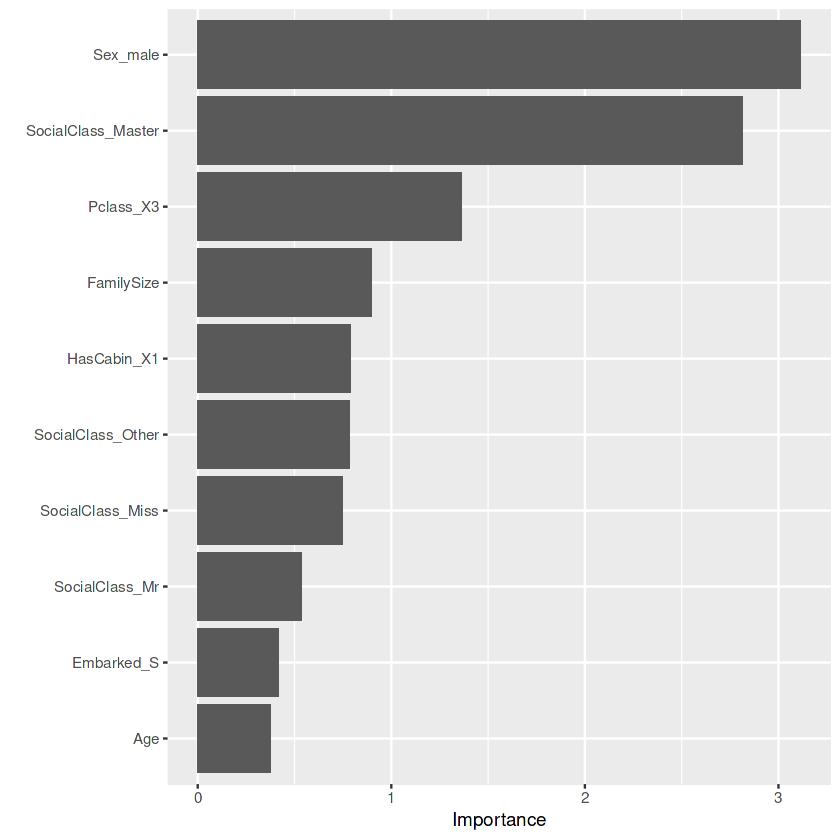

In [64]:
if (isTuningLogReg) {
    final_fit_logreg
} else {
    res_logreg
} %>% extract_fit_parsnip %>% vip

In [49]:
pred_logreg <- test %>% 
    select(PassengerId) %>% 
    bind_cols(
        ifelse(isTuningLogReg, 
               final_fit_logreg %>% extract_workflow, 
               res_logreg) %>% 
        predict(test_trans))
colnames(pred_logreg) <- c("PassengerId", "Survived")
pred_logreg %>% write.csv("/kaggle/working/submission.csv", row.names = F)

Warning message:
“Novel levels found in column 'Cabin': 'A11', 'A18', 'A21', 'A29', 'A9', 'B10', 'B11', 'B24', 'B26', 'B36', 'B45', 'B52 B54 B56', 'B61', 'C105', 'C116', 'C130', 'C132', 'C28', 'C31', 'C39', 'C51', 'C53', 'C55 C57', 'C6', 'C80', 'C89', 'C97', 'D22', 'D34', 'D38', 'D40', 'D43', 'E39 E41', 'E45', 'E52', 'E60', 'F', 'F E46', 'F E57'. The levels have been removed, and values have been coerced to 'NA'.”


### Single decision tree



In [40]:
model_dt <- decision_tree(tree_depth = tune(), min_n = tune(), cost_complexity = tune()) %>% 
    set_engine("rpart") %>% 
    set_mode("classification")
wflow_dt <- wflow %>% update_model(model_dt)

grid_dt  <- grid_regular(tree_depth(), min_n(), cost_complexity(), levels = 5)

tic()
res_dt <- wflow_dt %>% tune_grid(resamples = folds, grid = grid_dt, control = control_grid)
toc()

165.614 sec elapsed


165 seconds to tune a $5^3$ grid with 2x6-fold CV.

**Best model ($4^3$ grid, 2x6-fold CV; acc 0.7988827, AUC 0.8368906)**:
* cost_complexity: 1e-10
* tree_depth = 11
* min_n = 11

In [41]:
res_dt %>% show_best(metric = "accuracy", n = 20)

cost_complexity,tree_depth,min_n,.metric,.estimator,mean,n,std_err,.config
<dbl>,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1.000000e-10,11,11,accuracy,binary,0.8108486,12,0.009695788,Preprocessor1_Model009
1.000000e-10,15,11,accuracy,binary,0.8108486,12,0.009625142,Preprocessor1_Model010
1.778279e-08,11,11,accuracy,binary,0.8108486,12,0.009695788,Preprocessor1_Model034
1.778279e-08,15,11,accuracy,binary,0.8108486,12,0.009625142,Preprocessor1_Model035
3.162278e-06,11,11,accuracy,binary,0.8108486,12,0.009695788,Preprocessor1_Model059
3.162278e-06,15,11,accuracy,binary,0.8108486,12,0.009625142,Preprocessor1_Model060
5.623413e-04,11,11,accuracy,binary,0.8108486,12,0.009695788,Preprocessor1_Model084
5.623413e-04,15,11,accuracy,binary,0.8108486,12,0.009625142,Preprocessor1_Model085
1.000000e-10,8,11,accuracy,binary,0.8097414,12,0.007835684,Preprocessor1_Model008


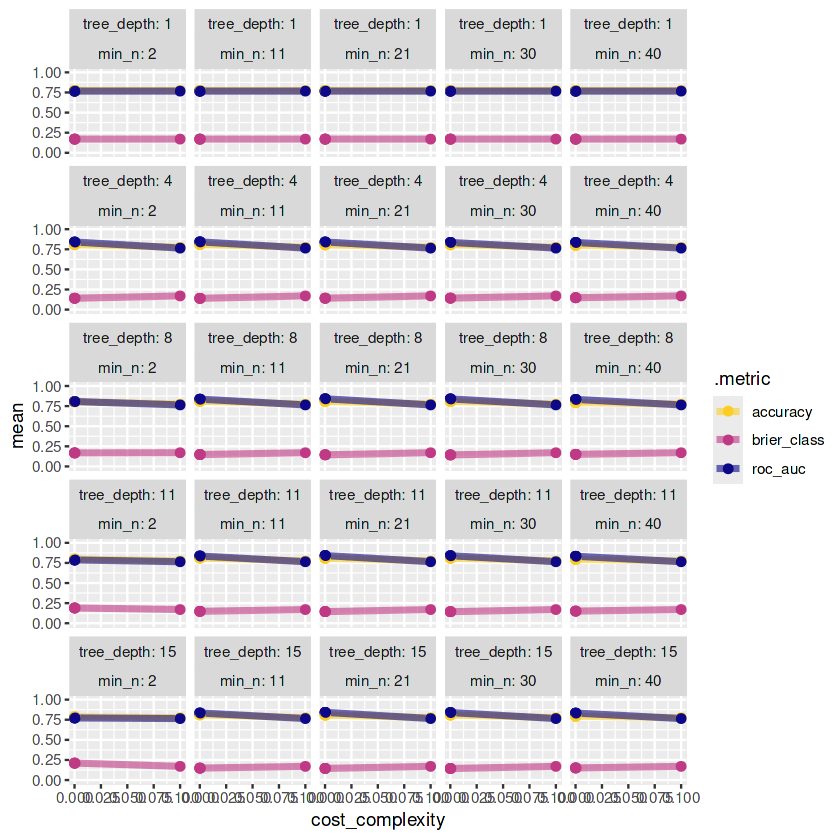

In [42]:
res_dt %>% collect_metrics %>% 
    ggplot(aes(cost_complexity, mean, color = .metric)) + 
    facet_wrap(tree_depth ~ min_n, labeller = "label_both") +
    geom_line(linewidth = 1.5, alpha = .6) + 
    geom_point(size = 2) + 
    scale_color_viridis_d(option = "plasma", begin = .9, end = 0) +
    ylim(0, 1)

#### Metrics: Single Decision Tree

In [43]:
best_model_dt <- res_dt %>% select_best(metric = "accuracy")
final_wf_dt   <- wflow_dt %>% finalize_workflow(best_model_dt)
final_fit_dt  <- final_wf_dt %>% last_fit(split)
final_fit_dt %>% collect_metrics

.metric,.estimator,.estimate,.config
<chr>,<chr>,<dbl>,<chr>
accuracy,binary,0.7988827,Preprocessor1_Model1
roc_auc,binary,0.8368906,Preprocessor1_Model1
brier_class,binary,0.1591640,Preprocessor1_Model1


### Bagging



In [71]:
library(baguette)
model_bag <- bag_tree(class_cost = 1, tree_depth = tune(), min_n = tune(), cost_complexity = tune()) %>% 
    set_engine("rpart") %>% 
    set_mode("classification")
grid_bag  <- grid_regular(tree_depth(), min_n(), cost_complexity(), levels = 6)

wflow_bag <- wflow %>% update_model(model_bag)

tic()
res_bag <- wflow_bag %>% tune_grid(resamples = folds, grid = grid_bag, control = control_grid)
toc()

1296.167 sec elapsed


1300 seconds to tune on a $6^3$ grid using 2x6-fold CV.

**Best model (tuned on a $6^3$ grid using 2x6-fold CV; acc 0.8212291, AUC 0.8546113)**:
* cost_complexity: 1e-10
* tree_depth: 15
* min_n: 14

In [72]:
res_bag %>% show_best(metric = "accuracy", n = 20)

cost_complexity,tree_depth,min_n,.metric,.estimator,mean,n,std_err,.config
<dbl>,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
3.981072e-07,12,9,accuracy,binary,0.8338699,12,0.005652795,Preprocessor1_Model083
6.309573e-09,12,17,accuracy,binary,0.8316139,12,0.006654564,Preprocessor1_Model053
2.511886e-05,15,9,accuracy,binary,0.8310433,12,0.007012451,Preprocessor1_Model120
1.584893e-03,9,9,accuracy,binary,0.8304840,12,0.008642544,Preprocessor1_Model154
3.981072e-07,15,24,accuracy,binary,0.8299323,12,0.006460014,Preprocessor1_Model096
6.309573e-09,15,9,accuracy,binary,0.8299134,12,0.008681749,Preprocessor1_Model048
1.000000e-10,9,2,accuracy,binary,0.8293692,12,0.006023818,Preprocessor1_Model004
1.000000e-10,15,17,accuracy,binary,0.8293465,12,0.010100990,Preprocessor1_Model018
1.584893e-03,15,17,accuracy,binary,0.8293465,12,0.007597544,Preprocessor1_Model162


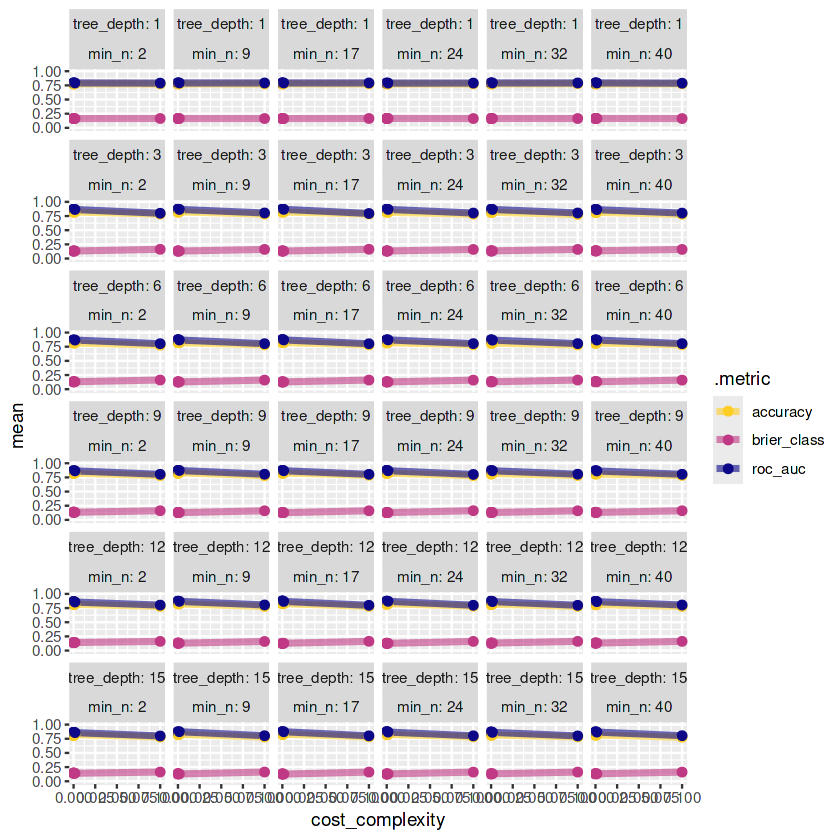

In [73]:
res_bag %>% collect_metrics %>% 
    ggplot(aes(cost_complexity, mean, color = .metric)) + 
    facet_wrap(tree_depth ~ min_n, labeller = "label_both") +
    geom_line(linewidth = 1.5, alpha = .6) + 
    geom_point(size = 2) + 
    scale_color_viridis_d(option = "plasma", begin = .9, end = 0) +
    ylim(0, 1)

#### Metrics: Bagging

In [74]:
best_model_bag <- res_bag %>% select_best(metric = "accuracy")
final_wf_bag   <- wflow_bag %>% finalize_workflow(best_model_bag)
final_fit_bag  <- final_wf_bag %>% last_fit(split)
final_fit_bag %>% collect_metrics

.metric,.estimator,.estimate,.config
<chr>,<chr>,<dbl>,<chr>
accuracy,binary,0.8212291,Preprocessor1_Model1
roc_auc,binary,0.8546113,Preprocessor1_Model1
brier_class,binary,0.1423009,Preprocessor1_Model1


In [75]:
pred_bag <- test %>% select(PassengerId) %>% bind_cols(final_fit_bag %>% extract_workflow %>% predict(test_trans))
colnames(pred_bag) <- c("PassengerId", "Survived")
pred_bag %>% write.csv("/kaggle/working/submission.csv", row.names = F)

Warning message:
“Novel levels found in column 'Cabin': 'A11', 'A18', 'A21', 'A29', 'A9', 'B10', 'B11', 'B24', 'B26', 'B36', 'B45', 'B52 B54 B56', 'B61', 'C105', 'C116', 'C130', 'C132', 'C28', 'C31', 'C39', 'C51', 'C53', 'C55 C57', 'C6', 'C80', 'C89', 'C97', 'D22', 'D34', 'D38', 'D40', 'D43', 'E39 E41', 'E45', 'E52', 'E60', 'F', 'F E46', 'F E57'. The levels have been removed, and values have been coerced to 'NA'.”


### Gradient Boosted Trees



It's my first time working with gradient boosted trees, so I'm not sure which hyperparameters to tune, since there are many. Earlier tests seemed to show that the learning_rate does not have a huge effect on our outcome, and trees should also default to a decent parameter. I will try tuning tree_depth, mtry and min_n on a $4^3$ grid.

In [48]:
model_gboost <- boost_tree(tree_depth = tune(), mtry = tune(), min_n = tune()) %>% set_engine("xgboost") %>% set_mode("classification")
grid_gboost  <- grid_regular(tree_depth(), mtry() %>% finalize(train_trans), min_n(), levels = 4)

wflow_gboost <- wflow %>% update_model(model_gboost)
tic()
res_gboost   <- wflow_gboost %>% tune_grid(resamples = folds, grid = grid_gboost, control = control_grid)
toc()

60.138 sec elapsed


60 seconds to run on a $4^3$ grid, tuning on 2x6-fold CV.

**Best model (tuned on a $4^3$ grid using 2x6-fold CV; acc 0.8100559, AUC 0.8654809):**
* mtry: 16
* min_n: 2
* tree_depth: 10

Best params on a 3^5 grid:
* mtry = 8
* trees = 1000
* min_n = 2
* tree_depth = 8
* learn_rate = 3.162278e-6

In [49]:
res_gboost %>% show_best(metric = "accuracy", n = 20)

mtry,min_n,tree_depth,.metric,.estimator,mean,n,std_err,.config
<int>,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
16,2,10,accuracy,binary,0.8389337,12,0.005033377,Preprocessor1_Model15
16,2,15,accuracy,binary,0.8355478,12,0.006573468,Preprocessor1_Model16
11,2,5,accuracy,binary,0.8327287,12,0.006728373,Preprocessor1_Model10
6,2,10,accuracy,binary,0.8310508,12,0.007609770,Preprocessor1_Model07
11,2,10,accuracy,binary,0.8299436,12,0.005565972,Preprocessor1_Model11
11,2,15,accuracy,binary,0.8293881,12,0.006263752,Preprocessor1_Model12
6,2,15,accuracy,binary,0.8293617,12,0.007196390,Preprocessor1_Model08
6,2,5,accuracy,binary,0.8287986,12,0.006908197,Preprocessor1_Model06
16,2,5,accuracy,binary,0.8282431,12,0.007282833,Preprocessor1_Model14


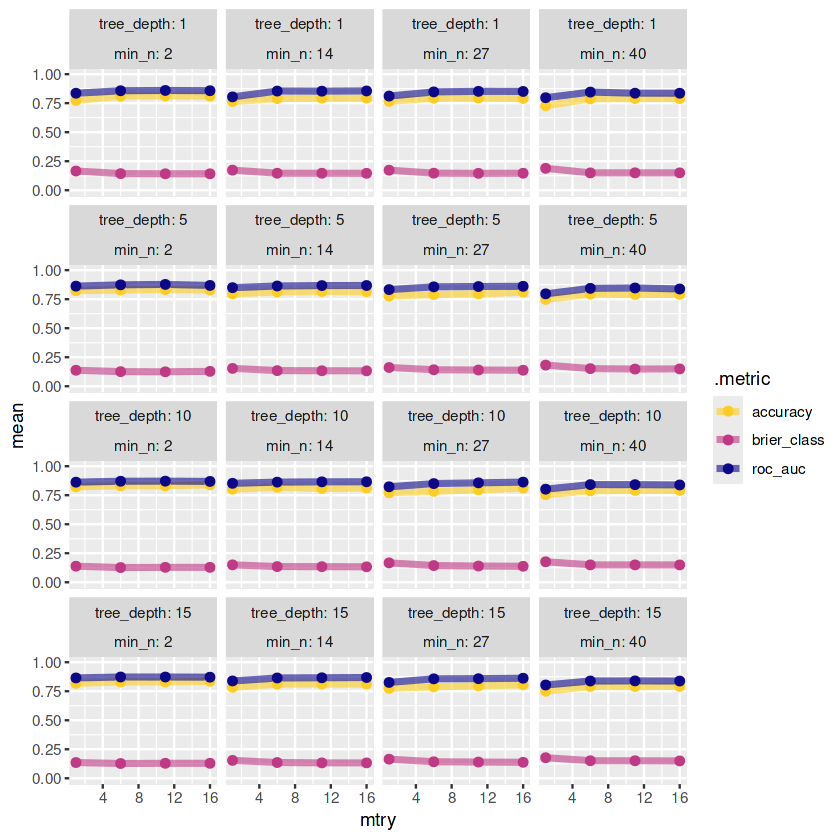

In [50]:
res_gboost %>% collect_metrics %>%
    ggplot(aes(mtry, mean, color = .metric)) + 
    facet_wrap(tree_depth ~ min_n, labeller = "label_both") +
    geom_line(linewidth = 1.5, alpha = .6) + 
    geom_point(size = 2) + 
    scale_color_viridis_d(option = "plasma", begin = .9, end = 0) +
    ylim(0, 1)

#### Metrics: Gradient Boosted Trees

In [51]:
(best_model_gboost <- res_gboost %>% select_best(metric = "accuracy"))

mtry,min_n,tree_depth,.config
<int>,<int>,<int>,<chr>
16,2,10,Preprocessor1_Model15


In [52]:
final_wf_gboost   <- wflow_gboost %>% finalize_workflow(best_model_gboost)
final_fit_gboost  <- final_wf_gboost %>% last_fit(split)
final_fit_gboost %>% collect_metrics

.metric,.estimator,.estimate,.config
<chr>,<chr>,<dbl>,<chr>
accuracy,binary,0.8100559,Preprocessor1_Model1
roc_auc,binary,0.8654809,Preprocessor1_Model1
brier_class,binary,0.1391027,Preprocessor1_Model1


### SVM



In [53]:
model_svm <- svm_rbf(cost = tune(), rbf_sigma = tune(), margin = tune()) %>% set_engine("kernlab") %>% set_mode("classification")
wflow_svm <- wflow %>% update_model(model_svm)

grid_svm  <- grid_regular(cost(), rbf_sigma(), svm_margin(), levels = 4)

tic()
res_svm   <- wflow_svm %>% tune_grid(resamples = folds, grid = grid_svm, control = control_grid)
toc()

180.621 sec elapsed


180 seconds to tune on a $4^3$ grid using 2x6-fold CV.

**Best model (tuned on a $4^3$ grid using 2x6-fold CV; acc 0.8044693, AUC 0.8534256):**
* cost: 32
* rbf_sigma: 0.0004641589
* margin: 0

In [54]:
res_svm %>% show_best(metric = "accuracy", n = 20)

cost,rbf_sigma,margin,.metric,.estimator,mean,n,std_err,.config
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
3.200000e+01,0.0004641589,0.00000000,accuracy,binary,0.8192908,12,0.0057565661,Preprocessor1_Model12
3.200000e+01,0.0004641589,0.06666667,accuracy,binary,0.8192908,12,0.0057565661,Preprocessor1_Model28
3.200000e+01,0.0004641589,0.13333333,accuracy,binary,0.8192908,12,0.0057565661,Preprocessor1_Model44
3.200000e+01,0.0004641589,0.20000000,accuracy,binary,0.8192908,12,0.0057565661,Preprocessor1_Model60
1.000000e+00,1.0000000000,0.00000000,accuracy,binary,0.7928910,12,0.0077000915,Preprocessor1_Model15
1.000000e+00,1.0000000000,0.06666667,accuracy,binary,0.7928910,12,0.0077000915,Preprocessor1_Model31
1.000000e+00,1.0000000000,0.13333333,accuracy,binary,0.7928910,12,0.0077000915,Preprocessor1_Model47
1.000000e+00,1.0000000000,0.20000000,accuracy,binary,0.7928910,12,0.0077000915,Preprocessor1_Model63
1.000000e+00,0.0004641589,0.00000000,accuracy,binary,0.7923318,12,0.0082623854,Preprocessor1_Model11


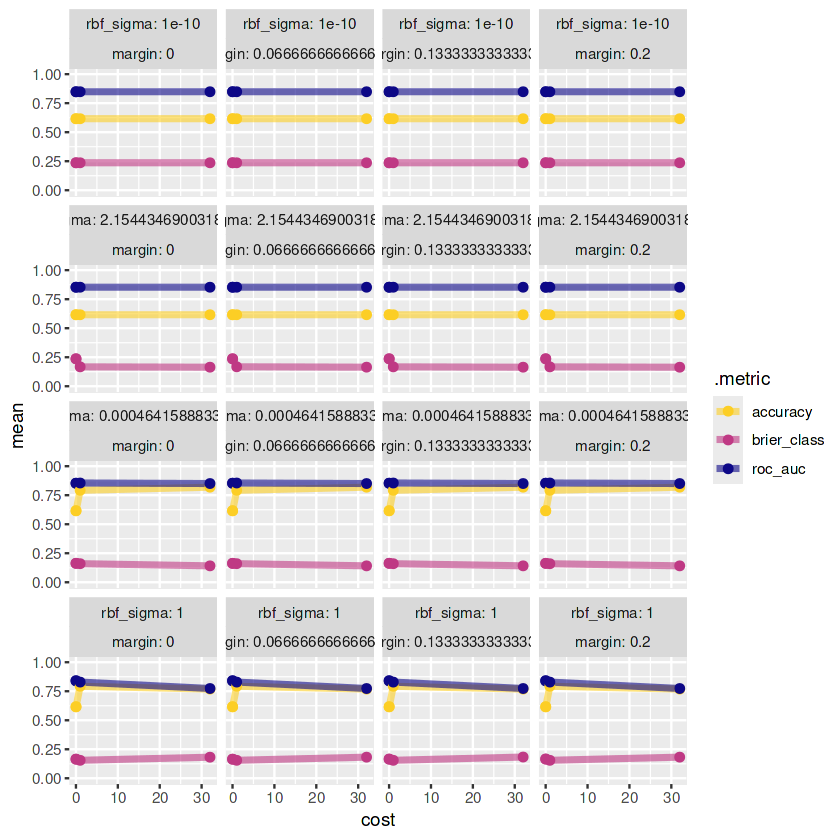

In [55]:
res_svm %>% collect_metrics %>% 
    ggplot(aes(cost, mean, color = .metric)) + 
    facet_wrap(rbf_sigma ~ margin, labeller = "label_both") +
    geom_line(linewidth = 1.5, alpha = .6) + 
    geom_point(size = 2) + 
    scale_color_viridis_d(option = "plasma", begin = .9, end = 0) +
    ylim(0, 1)

In [56]:
(best_model_svm <- res_svm %>% select_best(metric = "accuracy"))

cost,rbf_sigma,margin,.config
<dbl>,<dbl>,<dbl>,<chr>
32,0.0004641589,0,Preprocessor1_Model12


In [57]:
final_wf_svm  <- wflow_svm %>% finalize_workflow(best_model_svm)
final_fit_svm <- final_wf_svm %>% last_fit(split)
final_fit_svm %>% collect_metrics

.metric,.estimator,.estimate,.config
<chr>,<chr>,<dbl>,<chr>
accuracy,binary,0.8044693,Preprocessor1_Model1
roc_auc,binary,0.8534256,Preprocessor1_Model1
brier_class,binary,0.1491465,Preprocessor1_Model1


### K-Nearest Neighbor

In [58]:
model_knn <- nearest_neighbor(neighbors = tune(), weight_func = tune(), dist_power = tune()) %>% set_engine("kknn") %>% set_mode("classification")
wflow_knn <- wflow %>% update_model(model_knn)

grid_knn  <- grid_regular(neighbors(), weight_func(), dist_power(), levels = 5)

tic()
res_knn   <- wflow_knn %>% tune_grid(resamples = folds, grid = grid_knn, control = control_grid)
toc()

123.364 sec elapsed


Tuning knn on a $5^3$ grid using 2x6-fold CV took 228 seconds.

Best params:
* neighbors: 10
* weight_func: rectangular
* dist_power: 1.75

In [59]:
res_knn %>% show_best(metric = "accuracy", n = 20)

neighbors,weight_func,dist_power,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
10,rectangular,1.75,accuracy,binary,0.8142043,12,0.009444429,Preprocessor1_Model070
7,rectangular,1.00,accuracy,binary,0.8130895,12,0.008853096,Preprocessor1_Model054
7,rectangular,1.75,accuracy,binary,0.8130895,12,0.008379464,Preprocessor1_Model069
10,rectangular,2.00,accuracy,binary,0.8130782,12,0.010477212,Preprocessor1_Model075
7,rectangular,1.50,accuracy,binary,0.8119672,12,0.008553481,Preprocessor1_Model064
10,rectangular,1.50,accuracy,binary,0.8119634,12,0.009251002,Preprocessor1_Model065
7,rectangular,2.00,accuracy,binary,0.8114117,12,0.009258762,Preprocessor1_Model074
10,rectangular,1.25,accuracy,binary,0.8114079,12,0.009260009,Preprocessor1_Model060
10,rectangular,1.00,accuracy,binary,0.8108486,12,0.009278683,Preprocessor1_Model055


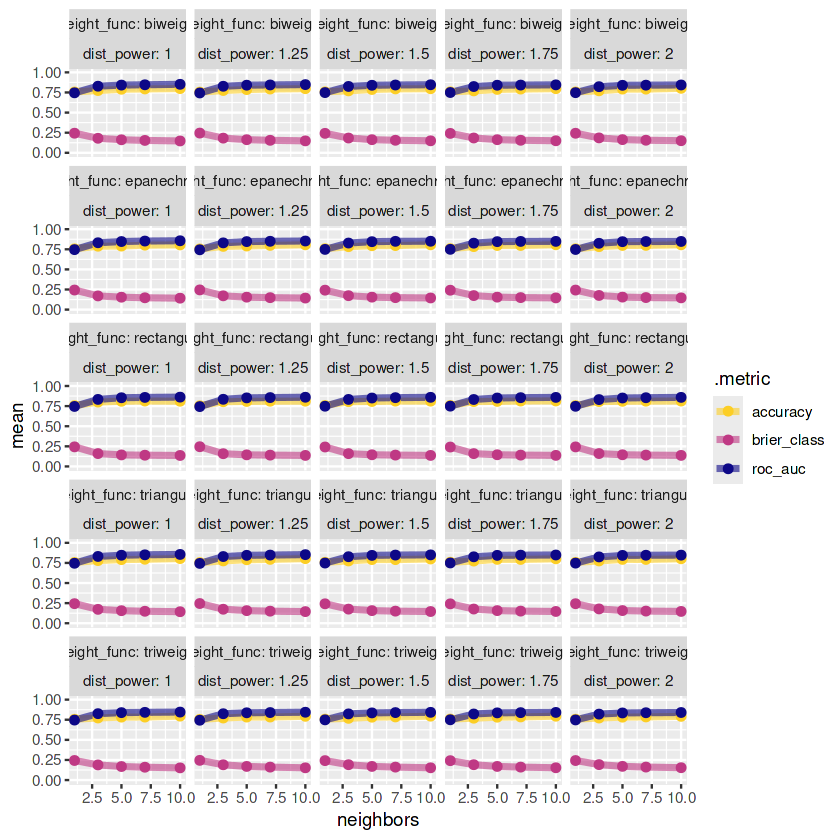

In [60]:
res_knn %>% collect_metrics %>% 
    ggplot(aes(neighbors, mean, color = .metric)) + 
    facet_wrap(weight_func ~ dist_power, labeller = "label_both") +
    geom_line(linewidth = 1.5, alpha = .6) + 
    geom_point(size = 2) + 
    scale_color_viridis_d(option = "plasma", begin = .9, end = 0) +
    ylim(0, 1)

In [61]:
(best_model_knn <- res_knn %>% select_best(metric = "accuracy"))

neighbors,weight_func,dist_power,.config
<int>,<chr>,<dbl>,<chr>
10,rectangular,1.75,Preprocessor1_Model070


In [62]:
final_wf_knn <- wflow_knn %>% finalize_workflow(best_model_knn)
final_fit_knn <- final_wf_knn %>% last_fit(split)
final_fit_knn %>% collect_metrics

.metric,.estimator,.estimate,.config
<chr>,<chr>,<dbl>,<chr>
accuracy,binary,0.7821229,Preprocessor1_Model1
roc_auc,binary,0.8532279,Preprocessor1_Model1
brier_class,binary,0.1529050,Preprocessor1_Model1


## Introducing democracy
We have now trained one of each of the following models:
* Logistic regression
* SVM
* KNN
* Decision Tree
* Random Forest
* Bagged Trees
* Gradient Boosted Trees

With 7 models in total, we will stack these and see how our results come out.

In [64]:
#stack <- stacks() %>% 
#    add_candidates(res_logreg) %>%
#    add_candidates(res_svm) %>%
#    add_candidates(res_knn) %>%
#    add_candidates(res_dt) %>%
#    add_candidates(res_rf) %>%
#    add_candidates(res_bag) %>%
#    add_candidates(res_gboost)

Warning message:
“Predictions from 68 candidates were identical to those from existing candidates
and were removed from the data stack.”
Warning message:
“Predictions from 40 candidates were identical to those from existing candidates
and were removed from the data stack.”
Warning message:
“Predictions from 212 candidates were identical to those from existing
candidates and were removed from the data stack.”
Warning message:
“The inputted `candidates` argument `res_bag` generated notes during
tuning/resampling. Model stacking may fail due to these issues; see
`collect_notes()` (`?tune::collect_notes()`) if so.”


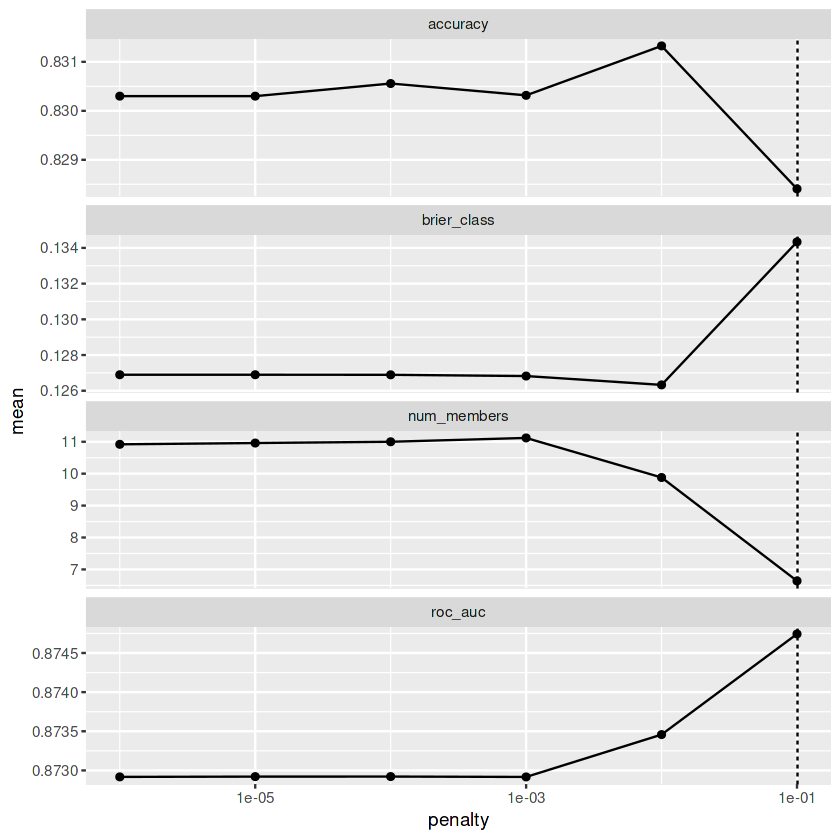

In [65]:
#tic()
#model_ensemble <- stack %>% blend_predictions %>% fit_members
#toc()
#model_ensemble %>% autoplot

In [66]:
#pred_final <- test %>% select(PassengerId) %>% bind_cols(predict(model_ensemble, test_trans))
#colnames(pred_final) <- c("PassengerId", "Survived")

Warning message:
“Novel levels found in column 'Cabin': 'A11', 'A18', 'A21', 'A29', 'A9', 'B10', 'B11', 'B24', 'B26', 'B36', 'B45', 'B52 B54 B56', 'B61', 'C105', 'C116', 'C130', 'C132', 'C28', 'C31', 'C39', 'C51', 'C53', 'C55 C57', 'C6', 'C80', 'C89', 'C97', 'D22', 'D34', 'D38', 'D40', 'D43', 'E39 E41', 'E45', 'E52', 'E60', 'F', 'F E46', 'F E57'. The levels have been removed, and values have been coerced to 'NA'.”
Warning message:
“Novel levels found in column 'Cabin': 'A11', 'A18', 'A21', 'A29', 'A9', 'B10', 'B11', 'B24', 'B26', 'B36', 'B45', 'B52 B54 B56', 'B61', 'C105', 'C116', 'C130', 'C132', 'C28', 'C31', 'C39', 'C51', 'C53', 'C55 C57', 'C6', 'C80', 'C89', 'C97', 'D22', 'D34', 'D38', 'D40', 'D43', 'E39 E41', 'E45', 'E52', 'E60', 'F', 'F E46', 'F E57'. The levels have been removed, and values have been coerced to 'NA'.”
Warning message:
“Novel levels found in column 'Cabin': 'A11', 'A18', 'A21', 'A29', 'A9', 'B10', 'B11', 'B24', 'B26', 'B36', 'B45', 'B52 B54 B56', 'B61', 'C105', 'C

In [67]:
#pred_final %>% write.csv("/kaggle/working/submission.csv", row.names = F)

In [ ]:
# Using workflow_set
#ctrl_grid <- control_stack_grid()
#wf_set    <- workflow_set(
#    preproc = list(rec = rec),
#    models = list(model_logreg, model_svm, model_knn, model_dt, model_rf, model_bag, model_gboost),
#    cross = T
#)

In [ ]:
#wf_set <- wf_set %>% option_add(control = ctrl_grid, metrics = metric_set(accuracy, roc_auc))

#tic()
#wf_set_trained <- wf_set %>% workflow_map("tune_grid", resamples = folds)
#toc()

In [ ]:
#tic()
#model_ensemble_st <- stacks() %>% add_candidates(wf_set_trained) %>% blend_predictions %>% fit_members
#toc()

In [ ]:
#model_ensemble_st %>% autoplot

In [ ]:
#pred_final <- test %>% select(PassengerId) %>% bind_cols(predict(model_ensemble_st, test_trans))
#colnames(pred_final) <- c("PassengerId", "Survived")
#pred_final %>% write.csv("/kaggle/working/submission.csv", row.names = F)